In [246]:
import sys, os
from sklearn import preprocessing
import matplotlib.pyplot as plt
# import matplotlib.ticker as tkr
import pandas as pd

from metrics import *

# Coarse grain clasification:
* Does input come from seen or unseen classes
* Requires classifier per class

# Fine grain
* decide on class
* if in labelled classes, use traditional classifier
* else use zero-shot classifier after feature augmentation

## Data augmentation:
* Topic translation
* Feature aug by using integrated Semantic knowledge to transfer knowldge learned from seen to unseen classes

In [4]:
df = pd.read_csv("D:\\Data\\medium-articles\\articles.csv")

In [7]:
def convert_to_integer(x):
    x = x.replace("K", "00")
    x = x.replace("k", "00")
    x = x.replace(".", "")

    return int(x)

df['claps_int'] = df['claps'].apply(convert_to_integer)

print(f"Max clap count: {max(df['claps_int'])}")
print(f"Min clap count: {min(df['claps_int'])}")

(337, 6)


,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


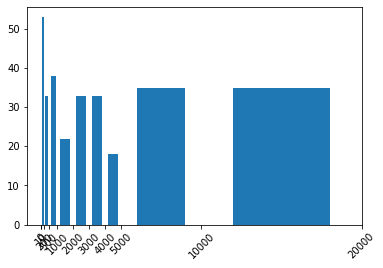

In [166]:
clap_bins=[0,10,200,500, 1000, 2000,3000,4000, 5000, 10000, 20000]

n, bins, patches = plt.hist(
    df['claps_int'],
    bins=clap_bins,
#     bins='auto',
    rwidth=0.6,
    orientation='vertical',
)
plt.xticks(rotation=45)
plt.xticks(clap_bins)
plt.show()


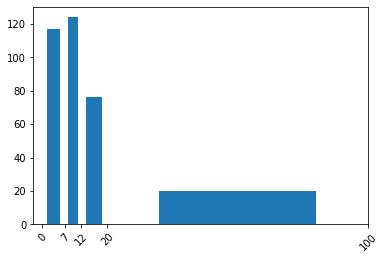

In [167]:
read_bins = [0,7,12,20, 100]

n, bins, patches = plt.hist(
    df['reading_time'],
    bins=read_bins,
#     bins='auto',
    rwidth=0.6,
    orientation='vertical',
)
plt.xticks(rotation=45)
plt.xticks(read_bins)
plt.show()


## Add category columns

In [163]:
le_read = preprocessing.LabelEncoder()
df['read_cat'] = le_read.fit_transform(df['reading_time'])

In [142]:
df['clap_bin'] = pd.cut(df['claps_int'].values, bins=bins,).astype(str)
df['clap_cat'] = le.fit_transform(df['clap_bin'])

In [164]:
df.head()

,author,claps,reading_time,link,title,text,claps_int,clap_cat,clap_bin,read_cat
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T...",8300,9,"(5000, 10000]",9
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...,1400,2,"(1000, 2000]",5
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...,2800,5,"(2000, 3000]",9
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...,1300,2,"(1000, 2000]",5
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...,935,8,"(500, 1000]",9


## Transform data for training

In [168]:
df.columns

Index(['author', 'claps', 'reading_time', 'link', 'title', 'text', 'claps_int',
       'clap_cat', 'clap_bin', 'read_cat'],
      dtype='object')

In [175]:
from transformers import *

In [183]:
model_config = (TFBertModel, BertTokenizer, 'bert-base-uncased')

model_class = model_config[0]
tokenizer_class = model_config[1]
pretrained_weights = model_config[2]


tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

100%|█████████████████████████████████████████████████████████████████| 536063208/536063208 [12:55<00:00, 691612.38B/s]


In [251]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import train_test_split

corpus = df['text'].values.tolist()
corpus = [re.sub(r"[^a-zA-z0-9.,?!]", "", text) for text in corpus]
vectorizer = TfidfVectorizer(max_features=2000)
x = vectorizer.fit_transform(corpus)
# print(vectorizer.get_feature_names())

In [252]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
y = df['clap_cat'].values.reshape(-1, 1)
# print(y.shape)
# print(y[:10])
y = enc.fit_transform(y)

In [253]:
x.shape

(337, 2000)

In [254]:
y.shape

(337, 10)

In [255]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2)

In [219]:
import tensorflow as tf
from tensorflow.keras import *

In [240]:
inputs = Input(shape=(2000,))
layer = layers.Dense(200, activation='relu')(inputs)
outputs = layers.Dense(10, activation=tf.nn.softmax)(layer)
model = Model(inputs, outputs)

In [241]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               400200    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2010      
Total params: 402,210
Trainable params: 402,210
Non-trainable params: 0
_________________________________________________________________


In [247]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['acc', f1_m, precision_m, recall_m]
               )

In [249]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=16, 
    epochs=5, 
    validation_split=0.2, 
#     callbacks=[WandbCallback()]
)

Train on 269 samples, validate on 68 samples
Epoch 1/5
269/269 [==============================] - 0s 199us/sample - loss: 0.1138 - acc: 0.9888 - f1_m: 0.9867 - precision_m: 1.0000 - recall_m: 0.9743 - val_loss: 2.0791 - val_acc: 0.3529 - val_f1_m: 0.3896 - val_precision_m: 0.5681 - val_recall_m: 0.3000
Epoch 2/5
269/269 [==============================] - 0s 193us/sample - loss: 0.1008 - acc: 0.9888 - f1_m: 0.9923 - precision_m: 1.0000 - recall_m: 0.9853 - val_loss: 2.1054 - val_acc: 0.3529 - val_f1_m: 0.3778 - val_precision_m: 0.5345 - val_recall_m: 0.3000
Epoch 3/5
269/269 [==============================] - 0s 201us/sample - loss: 0.0911 - acc: 0.9888 - f1_m: 0.9898 - precision_m: 0.9955 - recall_m: 0.9844 - val_loss: 2.1327 - val_acc: 0.3676 - val_f1_m: 0.4354 - val_precision_m: 0.6190 - val_recall_m: 0.3375
Epoch 4/5
269/269 [==============================] - 0s 193us/sample - loss: 0.0817 - acc: 0.9888 - f1_m: 0.9871 - precision_m: 0.9890 - recall_m: 0.9853 - val_loss: 2.1631 - val

In [259]:
scores = model.evaluate(
    x=x_test,
    y=y_test,
    verbose=1,
)

68/68 [==============================] - 0s 103us/sample - loss: 0.5178 - acc: 0.8676 - f1_m: 0.9293 - precision_m: 0.9544 - recall_m: 0.9062


In [260]:
{'test_'+metric: scores[index] for index, metric in enumerate(model.metrics_names)}

{'test_loss': 0.5178374639328789,
 'test_acc': 0.86764705,
 'test_f1_m': 0.9293143,
 'test_precision_m': 0.9544061,
 'test_recall_m': 0.90625}